# Bølgefysikk og fluidmekanikk numerisk prosjekt

In [18]:
from typing import Callable
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from pathlib import Path
from functools import partial

### Constants

In [19]:
L = 1.0 # [m]
g = 9.8 # [m/s^2]
theta_0 = 0.2 # [rad]
omega_0 = 0 # [rad/s]
q = 1.0 # [1/s]
w_0 = np.sqrt(g/L) # [1/s]
FD = 0.2 # [N]

### Solvers

In [20]:
def equation(t: float, y: np.ndarray, wD: float) -> np.ndarray:
    theta, omega = y[0], y[1]
    d_theta = omega
    d_omega = -g/L * theta - q*omega + FD * np.sin(wD*t)
    return np.array([d_theta, d_omega])

In [21]:
def RK45_solver(
    RHS: Callable,
    T: float,
    dt: float,
    theta_0: float, 
    omega_0: float
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """RK45-solver

    Args:
        RHS (Callable): _description_
        T (float): _description_
        dt (float): _description_
        theta_0 (float): _description_
        omega_0 (float): _description_

    Returns:
        tuple[np.ndarray, np.ndarray, np.ndarray]: theta, omega, t
    """
    t_vals = np.arange(0, T, dt)
    y0 = [theta_0, omega_0]
    t_interval = [0, T+dt]
    solution = solve_ivp(
        fun=RHS,
        t_span=t_interval,
        y0=y0,
        t_eval=t_vals
    )
    theta_vals = solution.y[0]
    omega_vals = solution.y[1]
    return theta_vals, omega_vals, t_vals


### Plotting

In [29]:
def plot_data(
    x_arrays: list[np.ndarray],
    y_arrays: list[np.ndarray],
    legends: list[str],
    xlabel: str,
    ylabel: str,
    title: str
) -> None:
    """Plot x_values to corresponding y_values 

    Args:
        x_arrays (list[np.ndarray]): _description_
        y_arrays (list[np.ndarray]): _description_
        legends (list[str]): _description_
        xlabel (str): _description_
        ylabel (str): _description_
        title (str): _description_
    """
    for x_arr, y_arr, legend in zip(x_arrays, y_arrays, legends):
        plt.plot(x_arr, y_arr, label=legend)
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    save_path = Path(__name__).parent / "Plots" / f"{title}.png"
    plt.savefig(save_path)

## Oppg. 1

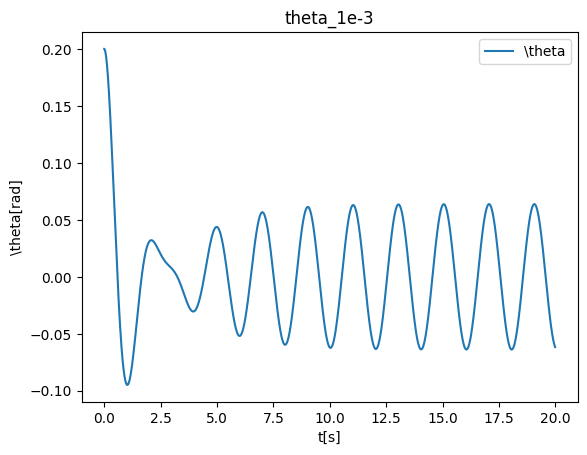

In [31]:
wD = 3.13 # [1/s]
T = 20 # [s]
dt = 0.01 # [s]
RHS = partial(equation, wD=wD)
theta_vals, omega_vals, t_vals = RK45_solver(
    RHS=RHS,
    T=T,
    dt=dt,
    theta_0=theta_0,
    omega_0=omega_0
)
plot_data(
    x_arrays=[t_vals],
    y_arrays=[theta_vals],
    legends=[r"\theta"],
    xlabel="t[s]",
    ylabel=r"\theta[rad]",
    title="theta_1e-3"
)